In [15]:
from fastai.vision.all import *
import timm 

In [16]:
path = "./chest_xray/"

In [17]:
# Define the DataBlock
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(460),
    batch_tfms=[*aug_transforms(size=224), Normalize.from_stats(*imagenet_stats)]
)

In [18]:
dls = dblock.dataloaders(path, bs=64)

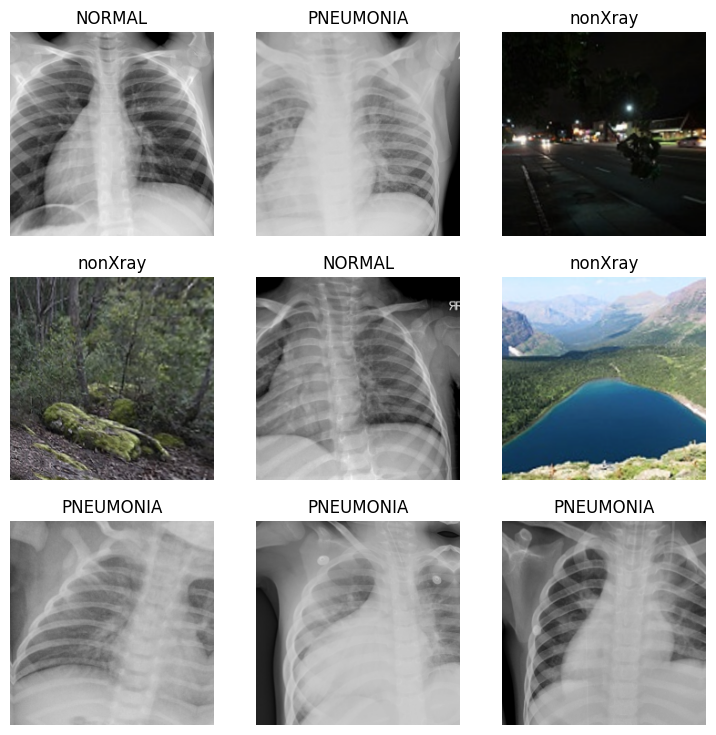

In [19]:
dls.show_batch()

In [20]:
# Define the custom Xception architecture
class XceptionModel(nn.Module):
    def __init__(self, num_classes=3, pretrained=True):
        super(XceptionModel, self).__init__()
        self.base_model = timm.create_model("xception", pretrained=pretrained)
        # Modify the last fully connected layer to match the number of classes
        self.fc = nn.Linear(self.base_model.num_features, num_classes)

    def forward(self, x):
        x = self.base_model.forward_features(x)
        x = F.adaptive_avg_pool2d(x, (1, 1)).reshape(x.size(0), -1)
        x = self.fc(x)
        return x

In [21]:
learn = Learner(dls, XceptionModel(num_classes=3), metrics=accuracy)

In [22]:
# Check if a saved model exists
model_path = "./mymodel"
if Path(model_path).exists():
    # Load the saved model if it exists
    learn.load(model_path)
else:
    # Create a new learner and train it if the saved model doesn't exist
    learn.fine_tune(5)
    # Save the trained model
    learn.save(model_path)


epoch,train_loss,valid_loss,accuracy,time
0,0.158645,0.096030,0.971799,4:03:49


epoch,train_loss,valid_loss,accuracy,time
0,0.071221,0.081368,0.968979,3:59:18
1,0.084008,0.148325,0.952059,4:00:33
2,0.068173,0.045788,0.987028,3:59:51
3,0.043790,0.038267,0.985336,3:55:54
4,0.034188,0.032512,0.988720,3:56:00


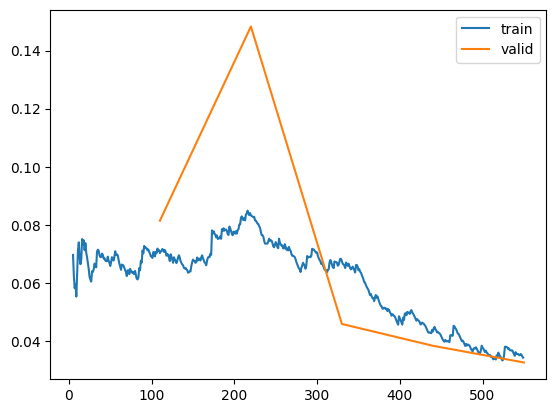

In [23]:
learn.recorder.plot_loss()

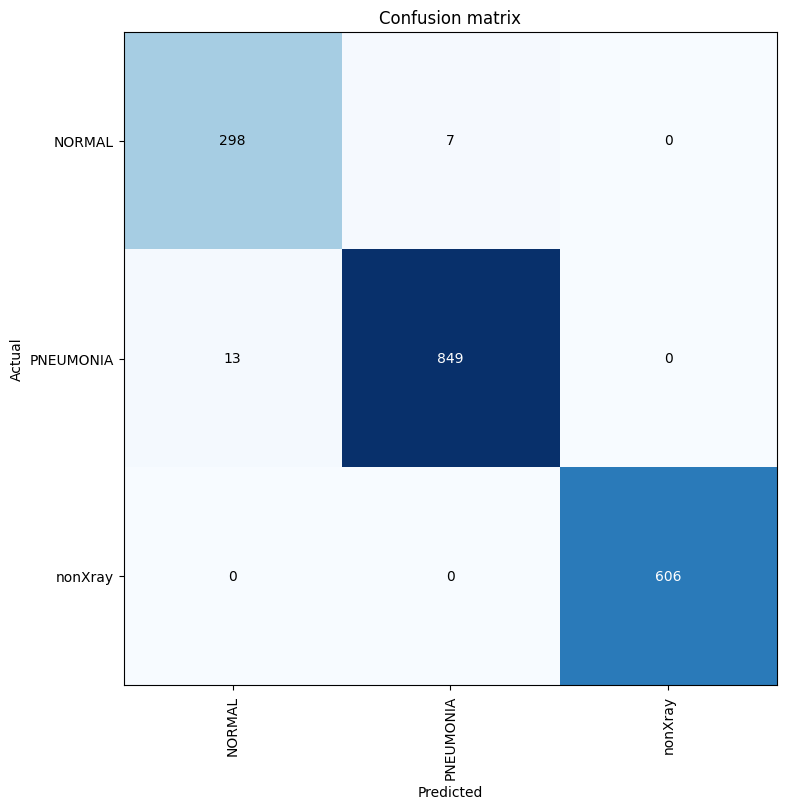

In [28]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(8, 8))